In [5]:
import torch, pickle, argparse
from tqdm import tqdm
import importlib
import matplotlib.pyplot as plt

In [21]:
args = {
    "run_id": "2",
    "data_path": "data/2024-10-13_PC1D_process10_data.pkl",
    "device": "cuda",
    "n_samples": 10,
    "epochs": 1000,
    "lr": 1e-3,
    "hidden_dim": 20,
    "step": 50,
    "encoder_hidden_dim": 128,
    "encoder_latent_dim": 10,
    "encoder_path": "encoder_run_2",
    "material_model": "m_dependent_b",
}

In [22]:
args = argparse.Namespace(**args)   


mm = importlib.import_module(args.material_model)
from util import LossFunction
from m_encoder import *

device = torch.device(args.device if torch.cuda.is_available() else "cpu")

with open(args.data_path, "rb") as f:
    data = pickle.load(f)


N = args.n_samples
step = args.step

e = torch.tensor(data["strain"][:N, ::step], dtype=torch.float32).to(device)
e_dot = torch.tensor(data["strain_rate"][:N, ::step], dtype=torch.float32).to(device)
s = torch.tensor(data["stress"][:N, ::step], dtype=torch.float32).to(device)
E = torch.tensor(data["E"][:N], dtype=torch.float32).to(device)
nu = torch.tensor(data["nu"][:N], dtype=torch.float32).to(device)

loss_function = LossFunction()

ae_E = AutoEncoder(E.shape[1], args.encoder_hidden_dim, args.encoder_latent_dim).to(
    device
)
ae_nu = AutoEncoder(nu.shape[1], args.encoder_hidden_dim, args.encoder_latent_dim).to(
    device
)

ae_E.load_state_dict(torch.load(f"{args.encoder_path}/ae_E.pth", weights_only=True, map_location=torch.device('cpu')))
ae_nu.load_state_dict(torch.load(f"{args.encoder_path}/ae_nu.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

E reconstruction error: 0.002040914027020335
nu reconstruction error: 0.001317610265687108


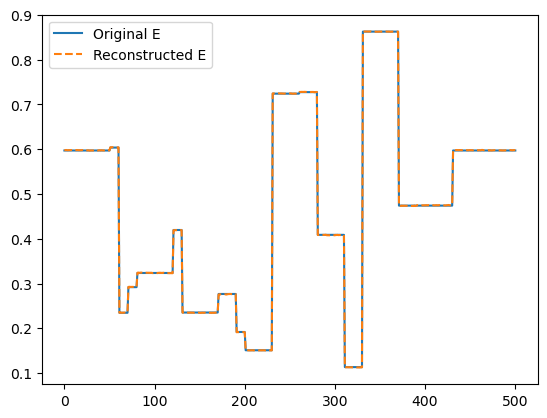

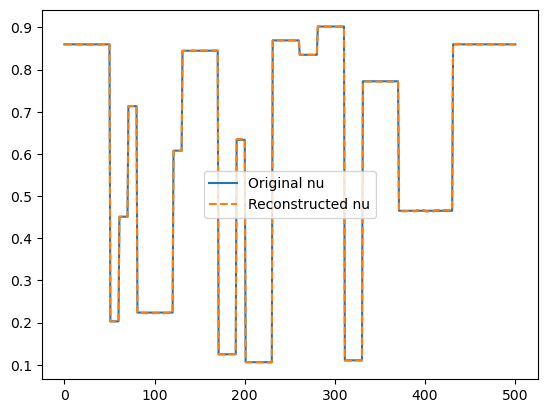

In [23]:
n = 8
E_recon = ae_E(E).detach().numpy()
nu_recon = ae_nu(nu).detach().numpy()
print("E reconstruction error:", loss_function.relative_error(torch.tensor(E_recon), E).item())
print("nu reconstruction error:", loss_function.relative_error(torch.tensor(nu_recon), nu).item())
plt.figure()
plt.plot(E.detach().numpy()[n], label='Original E')
plt.plot(E_recon[n], '--', label='Reconstructed E')
plt.legend()
plt.figure()
plt.plot(nu.detach().numpy()[n], label='Original nu')
plt.plot(nu_recon[n], '--', label='Reconstructed nu')
plt.legend()
plt.show()


In [24]:
energy_input_dim = args.encoder_latent_dim * 2 + 2
energy_hidden_dim = args.hidden_dim
dissipation_input_dim = args.encoder_latent_dim * 2 + 2
dissipation_hidden_dim = args.hidden_dim

vmm = mm.ViscoelasticMaterialModelM(
    energy_input_dim,
    energy_hidden_dim,
    dissipation_input_dim,
    dissipation_hidden_dim,
    ae_E.encoder,
    ae_nu.encoder,
).to(device)

vmm.load_state_dict(torch.load(f"material_model_run_{args.run_id}/vmm_m.pth", weights_only=True, map_location=torch.device('cpu')))

spred, xi = mm.prediction_step_M(vmm, e, e_dot, E, nu)

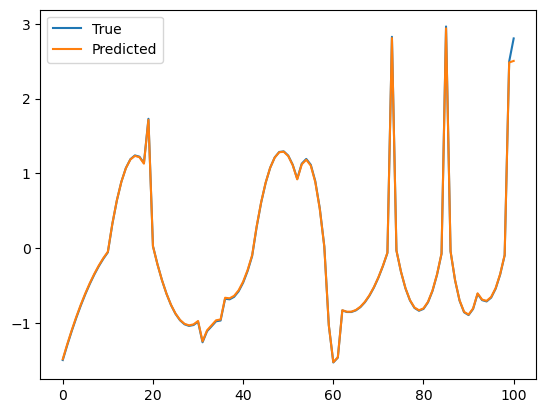

In [25]:
plt.plot(s[0, :, 0].cpu().detach().numpy(), label="True")
plt.plot(spred[0, :, 0].cpu().detach().numpy(), label="Predicted")
plt.legend()